# <u> Summary </u>  


*   Install packages
*   Pre-processing
  * Data
  * Feature extraction
      * First feature
      * Second feature
      * Essentia feature part 1
      * Essentia feature part 2
  * Utils
  * Compute
      * First feature
      * Second feature
      * Third feature
      * Fourth feature
* Checkpoint
* Model Regression
  * XGBoost
  * LightGBM
  * Fine tunning-XGBoost
  * Fine tunning-
* Train fine tuned
  * XGBoost
  * LightGBM
* Submission

# Install packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
%pip install essentia
%pip install pydub
%pip install Signal_Analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.8/378.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Signal_Analysis: filename=Signal_Analysis-0.1.26-py3-none-any.whl size=14514 sha256=5d9ec04e574c33723d0da2fa5ed1b6971003499bc21d1aa574aa399de2fbdb91
  Stored in directory: /root/.cache/pip/wheels/86/01/28/9bc7466d719ebd4787393b326a283c4ca829112078c6293254
Successfully built Signal_Analysis


In [ ]:
from pydub import AudioSegment
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random
import librosa
from IPython.display import Audio

import Signal_Analysis.features.signal
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis

from numpy import loadtxt
import xgboost as xgb
import essentia.standard as es
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

# Pre-processing

## Data


In [ ]:
def load_and_preprocess_data(data_df, train = False):
    audio_data = []
    for index, row in data_df.iterrows():

        input_audio, sample_rate = librosa.load(row['mp3_filepath'])

        if train :

          audio_data.append({
              'id': row['id'],
              'mp3_file_path': row['mp3_filepath'],
              'input_audio': input_audio,
              'sample_rate': sample_rate
          })

        else:

          audio_data.append({
              'id': row['id'],
              'mp3_file_path': row['mp3_filepath'],
              'input_audio': input_audio,
              'sample_rate': sample_rate,
              'year': row['year']

          })

    audio_df = pd.DataFrame(audio_data)

    return audio_df

## Feature extraction


In [ ]:
# Load train set
df =  pd.read_csv('train_dataset.csv')
df = load_and_preprocess_data(df)
df.to_pickle('df.pkl')

# Load test set
df_test= pd.read_csv('test_dataset.csv')
df_test = load_and_preprocess_data(df_test, True)
df_test.to_pickle('df_test.pkl')

In [ ]:
# Skip reproccesing
df_test = pd.read_pickle('df_test.pkl')
df = pd.read_pickle('df.pkl')

### First variables


In [ ]:
def extract_audio_features(y, sr, id):
    try:


        # Calculer le tempo (rythme) de la musique
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

        # Calculer les MFCC (Mel-frequency cepstral coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mean_mfcc = np.mean(mfcc, axis=1)
        var_mfcc = np.var(mfcc, axis=1)

        # Calculer d'autres caractéristiques
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        key = librosa.feature.tonnetz(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)

        # Calculer la moyenne et la variance des caractéristiques
        mean_chroma = np.mean(chroma, axis=1)
        var_chroma = np.var(chroma, axis=1)
        mean_spectral_centroid = np.mean(spectral_centroid)
        var_spectral_centroid = np.var(spectral_centroid)
        mean_spectral_contrast = np.mean(spectral_contrast, axis=1)
        var_spectral_contrast = np.var(spectral_contrast, axis=1)
        mean_key = np.mean(key, axis=1)
        var_key = np.var(key, axis=1)
        mean_rmse = np.mean(rmse)
        var_rmse = np.var(rmse)

        # Other features
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_mean = np.mean(pitches[pitches > 0])
        pitch_var = np.var(pitches[pitches > 0])

        zero_crossings_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y=y))
        zero_crossings_rate_var = np.var(librosa.feature.zero_crossing_rate(y=y))

        duration = librosa.get_duration(y=y, sr=sr)

        energy_start = librosa.effects.split(y)[0][0]
        energy_end = librosa.effects.split(y)[0][-1]

        # Calculer la transformée de Fourier discrète (DFT)
        dft = np.fft.fft(y)

        # Calculer les coefficients de magnitude (module) de la DFT
        magnitude = np.abs(dft)

        # Calculer les fréquences correspondantes aux coefficients de la DFT
        frequencies = np.fft.fftfreq(len(magnitude), d=1/sr)

        # Sélectionner uniquement les coefficients positifs (partie réelle)
        positive_frequencies = frequencies[:len(frequencies)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]

        mean_positive_frequencies = np.mean(positive_frequencies)
        var_positive_frequencies = np.var(positive_frequencies)

        mean_positive_magnitude = np.mean(positive_magnitude)
        var_positive_magnitude = np.var(positive_magnitude)

        # Créer un dictionnaire de caractéristiques
        features_dict = {
            "id": [id],
            "Tempo": [tempo],
            "Mean_Chroma_1": [mean_chroma[0]],
            "Mean_Chroma_2": [mean_chroma[1]],
            "Mean_Chroma_3": [mean_chroma[2]],
            "Mean_Chroma_4": [mean_chroma[3]],
            "Mean_Chroma_5": [mean_chroma[4]],
            "Mean_Chroma_6": [mean_chroma[5]],
            "Mean_Chroma_7": [mean_chroma[6]],
            "Mean_Chroma_8": [mean_chroma[7]],
            "Var_Chroma_1": [var_chroma[0]],
            "Var_Chroma_2": [var_chroma[1]],
            "Var_Chroma_3": [var_chroma[2]],
            "Var_Chroma_4": [var_chroma[3]],
            "Var_Chroma_5": [var_chroma[4]],
            "Var_Chroma_6": [var_chroma[5]],
            "Var_Chroma_7": [var_chroma[6]],
            "Var_Chroma_8": [var_chroma[7]],
            "Mean_Spectral_Centroid": [mean_spectral_centroid],
            "Var_Spectral_Centroid": [var_spectral_centroid],
            "Mean_Spectral_Contrast_1": [mean_spectral_contrast[0]],
            "Mean_Spectral_Contrast_2": [mean_spectral_contrast[1]],
            "Mean_Spectral_Contrast_3": [mean_spectral_contrast[2]],
            "Mean_Spectral_Contrast_4": [mean_spectral_contrast[3]],
            "Mean_Spectral_Contrast_5": [mean_spectral_contrast[4]],
            "Var_Spectral_Contrast_1": [var_spectral_contrast[0]],
            "Var_Spectral_Contrast_2": [var_spectral_contrast[1]],
            "Var_Spectral_Contrast_3": [var_spectral_contrast[2]],
            "Var_Spectral_Contrast_4": [var_spectral_contrast[3]],
            "Var_Spectral_Contrast_5": [var_spectral_contrast[4]],
            "Mean_Key_1": [mean_key[0]],
            "Mean_Key_2": [mean_key[1]],
            "Mean_Key_3": [mean_key[2]],
            "Var_Key_1": [var_key[0]],
            "Var_Key_2": [var_key[1]],
            "Var_Key_3": [var_key[2]],
            "Mean_RMSE": [mean_rmse],
            "Var_RMSE": [var_rmse],
            "Mean_Pitch" :[pitch_mean]


        }
        for i in range(13):
            features_dict[f"Mean_MFCC_{i+1}"] = [mean_mfcc[i]]
            features_dict[f"Var_MFCC_{i+1}"] = [var_mfcc[i]]

        features_dict.update({
                "Mean_Pitch": [pitch_mean],
                "Var_Pitch": [pitch_var],
                "Mean_Zero_Crossings_Rate": [zero_crossings_rate_mean],
                "Var_Zero_Crossings_Rate": [zero_crossings_rate_var],
                "Duration": [duration],
                "Energy_Start": [energy_start],

                "Energy_End": [energy_end],

                "Mean_Positive_Frequencies": [mean_positive_frequencies],
                "Var_Positive_Frequencies": [var_positive_frequencies],
                "Mean_Positive_Magnitude": [mean_positive_magnitude],
                "Var_Positive_Magnitude": [var_positive_magnitude]
            })


        features_df = pd.DataFrame(features_dict)

        return features_df
    except Exception as e:
        print(f"Erreur lors de l'extraction des caractéristiques audio : {str(e)}")
        return None

### Second Features

In [ ]:
def extract_audio_features_2(y, sr, id):
  try:
    #### Compute the rollof

    # Approximate maximum frequencies with roll_percent=0.85
    rollof = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rollof_var = np.var(rollof)
    rollof_mean = np.mean(rollof)



    # Approximate maximum frequencies with roll_percent=0.99
    rollof_99 = librosa.feature.spectral_rolloff(y=y, sr=sr ,roll_percent=0.99)
    rollof_99_var = np.var(rollof_99)
    rollof_99_mean = np.mean(rollof_99)


    # Approximate minimum frequencies with roll_percent=0.01
    rollof_01 = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)
    rollof_01_var = np.var(rollof_01)
    rollof_01_mean = np.mean(rollof_01)


    ## Others

    skewness = skew(y, axis=0, bias=True)
    kurtosis_ = kurtosis(y, axis=0, bias=True)


    # spectral_bandwidth
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bw_var = np.var(spec_bw)
    spec_bw_mean = np.mean(spec_bw)


    # Harmonic and perceptual
    harm = librosa.effects.hpss(y=y)
    harm_var = np.var(harm)
    harm_mean = np.mean(harm)

    # Amplitude to db
    db = librosa.amplitude_to_db(y, ref=np.max)
    db_var = np.var(db)
    db_mean = np.mean(db)


    # Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_mean = np.mean(mfcc_delta)
    mfcc_delta_var = np.var(mfcc_delta)





    features_dict = {
          "id": [id],
          "rollof_var" : [rollof_var],
          "rollof_mean":[rollof_mean],
          "rollof_99_var": [rollof_99_var],
          "rollof_99_mean": [rollof_99_mean],
          "rollof_01_var": [rollof_01_var],
          "rollof_01_mean": [rollof_01_mean],
          "harm_var": [harm_var],
          "harm_mean": [harm_mean],
          "db_var": [db_var],
          "db_mean": [db_mean],
          "skewness": [skewness] ,
          'kurtosis':[kurtosis_],
          "mfcc_delta_mean": [mfcc_delta_mean] ,
          "mfcc_delta_var":[mfcc_delta_var]



      }


    features_df = pd.DataFrame(features_dict)

    return features_df

  except Exception as e:
    print(f"Erreur lors de l'extraction des caractéristiques audio : {str(e)}")
    return None

### Features with essentia package part 1





In [ ]:
# Initialisation of essentia algorithm
danceability_algo = es.Danceability()
spect_comp = es.SpectralComplexity()
tempo = es.PercivalBpmEstimator()
energy = es.Energy()
key = es.KeyExtractor()
eff_duration = es.EffectiveDuration()
HighResolutionFeatures_fct = es.HighResolutionFeatures()


In [ ]:
def extract_audio_features_essentia(y, sr, id):

  try:
    # Danceability
    danceability, _ = danceability_algo(y)

    # Spectral Complexity
    s_complx = spect_comp(y)

    # Tempo
    tempo_bpm = tempo(y)

    # Energy
    energ = energy(y)

    # Compute key
    key_c, scale, strength = key(y)

    # Effective duration
    effictive_duration = eff_duration(y)

    features_dict = {
        "id": [id],
        "danceability": [danceability],
        "spectral complexity": [s_complx],
        "tempo" :[tempo_bpm],
        "energy" : [energ],
        "key": [key_c],
        "scale": [scale],
        "strengh": [strength],
        "effective_duration": [effictive_duration]



        }


    features_df = pd.DataFrame(features_dict)

    return features_df

  except Exception as e:

    print(f"Erreur lors de l'extraction des caractéristiques audio : {str(e)}")
    return None

### Features with essentia package part 2

In [ ]:
# Essentia algo

OnsateR = es.OnsetRate()
Scale_band = es.TempoScaleBands()
Instant_Power = es.InstantPower()
Spectrum_vector = es.Spectrum()
Spectral_Peaks = es.SpectralPeaks()
Dissonance_fct = es.Dissonance()

Tonal_Extractor = es.TonalExtractor()
Tristimulus_f = es.Tristimulus()
Dynamic_Complexity = es.DynamicComplexity()
larm_f = es.Larm()


In [ ]:
def extract_audio_features_essentia2(y, sr, id):

  try:

    # Onset rate
    _, onsate_r = OnsateR(y)

    # InstantPower
    Instant_Power_real = Instant_Power(y)

    # Spectrum_vector features
    spectrom_v = Spectrum_vector(y)
    frequencies, magnitude = Spectral_Peaks(spectrom_v)
    frequency_mean = np.mean(frequencies)
    frequency_var = np.var(magnitude)
    magnitude_mean = np.mean(magnitude)
    magnitude_var = np.var(magnitude)
    dissonnance_real = Dissonance_fct(frequencies, magnitude)


    #Tonal extractor
    chords_changes_rate, chords_histogram, chords_key ,chords_number_rat,chords_progression ,chords_scale ,chords_strength ,hpcp,hpcp_highres ,key_key  ,key_scale  ,key_strength = Tonal_Extractor(y)
    chords_strength_mean = np.mean(chords_strength)
    chords_strength_var = np.var(chords_strength)
    chords_strength_sum = np.sum(chords_strength)

    # Trismulus
    Tristimulus_v = Tristimulus_f(frequencies, magnitude)
    Tristimulus1,Tristimulus2, Tristimulus3 = Tristimulus_v
    Tristimulus_var = np.var(Tristimulus_v)
    Tristimulus_mean = np.mean(Tristimulus_v)

    # Dynamic_Complexity
    dynamic_C ,loudness = Dynamic_Complexity(y)

    # Larm
    larm_real = larm_f(y)




    features_dict = {
        "id": [id],
        "Onsate_rate": [onsate_r],
        "Instant_Power" : [Instant_Power_real],
        "frequency_mean":[frequency_mean],
        "frequency_var":[frequency_var],
        "magnitude_mean":[magnitude_mean],
        "magnitude_var":[magnitude_var],
        "dissonnance_real": [dissonnance_real],

        "key_strength":[key_strength],
        "key_scale":[key_scale],
        "key_key":[key_key],
        "chords_strength_mean":[chords_strength_mean],
        "chords_strength_var":[chords_strength_var],
        "chords_strength_sum":[chords_strength_sum],
        "chords_scale":[chords_scale],
        "chords_number_rat":[chords_number_rat],
        "chords_key":[chords_key],
        "chords_changes_rate":[chords_changes_rate],
        "Tristimulus1":[Tristimulus1],
        "Tristimulus2":[Tristimulus2],
        "Tristimulus3":[Tristimulus3],
        "Tristimulus_var":[Tristimulus_var],
        "Tristimulus_mean":[Tristimulus_mean],
        "dynamic_C":[dynamic_C],
        "loudness":[loudness],
        "larm_real":[larm_real]
        }


    features_df = pd.DataFrame(features_dict)

    return features_df

  except Exception as e:

    print(f"Erreur lors de l'extraction des caractéristiques audio : {str(e)}")
    return None

### Utils


In [ ]:
def features_data(data_df, f_1 = 0):
    i = 0
    n = len(data_df)
    features_df = pd.DataFrame()
    if f_1 == 0 :
      for index, row in data_df.iterrows():


          if i % 200 == 0 :
            print(f"{i/n}%")

          features_df = pd.concat([features_df, extract_audio_features(row['input_audio'], row['sample_rate'], row['id'])])
          i += 1
    elif f_1 == 1 :
      for index, row in data_df.iterrows():

          if i % 200 == 0 :
            print(f"{i/n}%")

          features_df = pd.concat([features_df, extract_audio_features_2(row['input_audio'], row['sample_rate'], row['id'])])
          i += 1

    elif f_1 == 2 :
      for index, row in data_df.iterrows():

          if i % 200== 0 :
            print(f"{i/n}%")

          features_df = pd.concat([features_df, extract_audio_features_essentia2(row['input_audio'], row['sample_rate'], row['id'])])
          i += 1

    elif f_1 == 3 :
      for index, row in data_df.iterrows():

          if i % 200 == 0 :
            print(f"{round(i/n,3)}%")

          features_df = pd.concat([features_df, extract_audio_features_essentia(row['input_audio'], row['sample_rate'], row['id'])])
          i += 1

    return features_df

### Compute

### First features

In [ ]:
df_feat = features_data(df)
df_feat.to_csv('train_feat.csv',index=False)

0.0%


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7abdce63dcf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


Erreur lors de l'extraction des caractéristiques audio : no compiled object yet for <Library '<numba.np.ufunc.wrappers._GufuncWrapper object at 0x7abdc5c730d0>' at 0x7abdc5b20850>


KeyboardInterrupt: ignored

In [ ]:
df_test_feat = features_data(df_test)
df_test_feat.to_csv('test_feat.csv',index=False)

### Second features

In [ ]:
df_feat2 = features_data(df, 1)
df_feat2.to_csv('train_feat2.csv',index=False)

In [ ]:
df_feat2_test = features_data(df_test, 1)
df_feat2_test.to_csv('test_feat2.csv',index=False)

### Third feature

In [ ]:
df_feat_essentia_2 = features_data(df, f_1 = 2)
df_feat_essentia_2.to_csv('train_essentia_2.csv',index=False)

0.0%
0.13012361743656473%
0.26024723487312945%
0.3903708523096942%
0.5204944697462589%
0.6506180871828237%
0.7807417046193884%
0.9108653220559532%


In [ ]:
df_test_essentia_2 = features_data(df_test,f_1 = 2)
df_test_essentia_2.to_csv('test_essentia_2.csv',index=False)

0.0%
0.5194805194805194%


### Fourth feature

In [ ]:
df_feat_essentia = features_data(df, f_1 = 3)
df_feat_essentia.to_csv('train_feat_essentia.csv',index=False)

0.0%
0.13%
0.26%
0.39%
0.52%
0.651%
0.781%
0.911%


In [ ]:
df_feat_essentia_test = features_data(df_test,f_1 = 3)
df_feat_essentia_test.to_csv('train_feat_essentia_test.csv',index=False)

0.0%
0.519%


# Checkpoint

In [ ]:
# Skip reproccesing
df_test = pd.read_pickle('df_test.pkl')
df = pd.read_pickle('df.pkl')

df_test_feat = pd.read_csv('test_feat.csv')
df_feat = pd.read_csv('train_feat.csv')

df_feat2_test = pd.read_csv('test_feat2.csv')
df_feat2 = pd.read_csv('train_feat2.csv')

df_feat_essentia_test = pd.read_csv('train_feat_essentia_test.csv')
df_feat_essentia =  pd.read_csv('train_feat_essentia.csv')

df_test_essentia_2  = pd.read_csv('train_essentia_2.csv')
df_train_essentia_2  =  pd.read_csv('train_essentia_2.csv')


df_feat = df_feat.rename(columns={"id": "mp3_file_path"})
df_test_feat = df_test_feat.rename(columns={"id": "mp3_file_path"})

In [ ]:
df_feat_essentia = pd.get_dummies(df_feat_essentia, columns=['key',	'scale'	])
df_feat_essentia_test = pd.get_dummies(df_feat_essentia_test,columns=['key',	'scale'	])

In [ ]:
df_test_essentia_2  = df_test_essentia_2.drop(columns=['key_scale',	'key_key'	,'chords_scale'	,'chords_key'])
df_train_essentia_2  =  df_train_essentia_2.drop(columns=['key_scale',	'key_key'	,'chords_scale'	,'chords_key'])

## Concat

In [ ]:
temp = df.merge(df_feat, on='mp3_file_path')
temp = temp.merge(df_feat2, on='id')
temp = temp.merge(df_train_essentia_2, on='id')
train_ds = temp.merge(df_feat_essentia, on='id')

In [ ]:
temp = df_test.merge(df_test_feat, on='mp3_file_path')
temp= temp.merge(df_feat2_test, on='id')
temp = temp.merge(df_test_essentia_2, on='id')
test_ds = temp.merge(df_feat_essentia_test, on='id')

In [ ]:
train_ds['duration_squared'] = train_ds['Duration']**2

In [ ]:
test_ds ['duration_squared'] = test_ds ['Duration']**2

# Model-Regression

In [ ]:
X = train_ds[train_ds.columns.difference([	"id",	"mp3_file_path",	"input_audio",	"sample_rate",	"year"])]

In [ ]:
y = train_ds['year']

### XGBoost


In [ ]:
# Define XGBoost parameters for regression
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',             # Root Mean Squared Error as the evaluation metric
    'eta': 0.01,                        # Learning rate
    'max_depth': 10,                    # Maximum depth of the trees
    'lambda': 0.01,
    'alpha': 0.02}


# Convert data to DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Perform cross-validation
num_rounds = 500  # Adjust the number of boosting rounds as needed

In [ ]:
# Convert data to DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Perform cross-validation
num_rounds = 500  # Adjust the number of boosting rounds as needed

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_rounds,
    nfold=5,  # Number of folds in cross-validation
    metrics='rmse',
    early_stopping_rounds= 20,  # Stop training if no improvement in 10 rounds
    seed=42
)

# Extract the optimal number of rounds based on early stopping
optimal_rounds = np.argmin(cv_results['test-rmse-mean'])
print('RMSE test', cv_results['test-rmse-mean'].min())
# Train the final model with the optimal number of rounds
final_model = xgb.train(params, dtrain, num_boost_round=optimal_rounds)

# Evaluate the final model
y_pred = final_model.predict(dtrain)
rmse = mean_squared_error(y, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE) on full dataset: {rmse}')


RMSE test 10.283152511277553
Root Mean Squared Error (RMSE) on full dataset: 2.2570867605997718


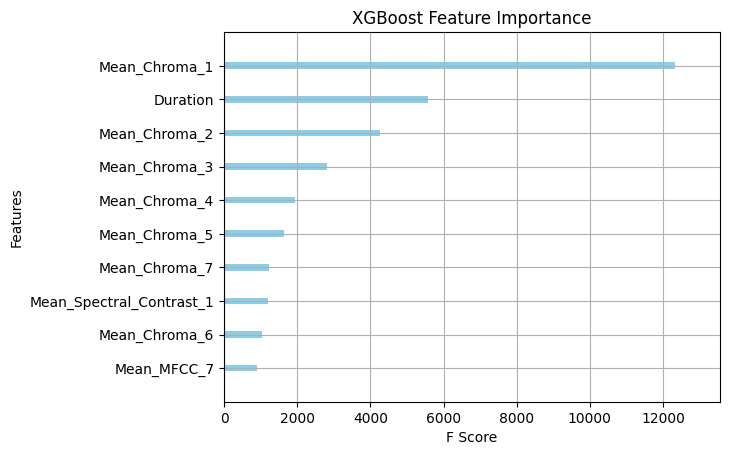

In [ ]:
# Plot feature importance
xgb.plot_importance(final_model, importance_type='weight', show_values=False,max_num_features=10, title='XGBoost Feature Importance', xlabel='F Score', ylabel='Features', color='skyblue')
plt.show()

## LightGBM


In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMRegressor()

In [ ]:
d_train= lgb.Dataset(X, label=y)

In [ ]:
params_lgb = {
    'objective': 'regression',
    'metric': 'mse',  # Mean Squared Error
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Adjust based on your dataset
    'learning_rate': 0.05,  # Adjust based on your dataset
    'feature_fraction': 0.9,  # Fraction of features to consider in each boosting round
    'bagging_fraction': 0.8,  # Fraction of data to use in each boosting round
    'bagging_freq': 5,  # Frequency for bagging
    'verbose': 0,  # Set to 1 for more information during training
}


In [ ]:
cv_results =  lgb.cv(
    params_lgb,
    d_train,
    num_boost_round=1000,
    nfold=5,  # Number of folds in cross-validation
    metrics='rmse',
    stratified=False,
    seed=42
)

# Extract the optimal number of rounds based on early stopping
optimal_rounds = np.argmin(cv_results['valid rmse-mean'])
print('RMSE test:', cv_results['valid rmse-mean'][optimal_rounds])

# Train the final model with the optimal number of rounds
final_model = lgb.train(params_lgb , d_train, num_boost_round=optimal_rounds)

# Evaluate the final model
y_pred = final_model.predict(X)
rmse = mean_squared_error(y, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE) on full dataset: {rmse}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
RMSE test: 8.997978723404346
Root Mean Squared Error (RMSE) on full dataset: 3.010276859352567


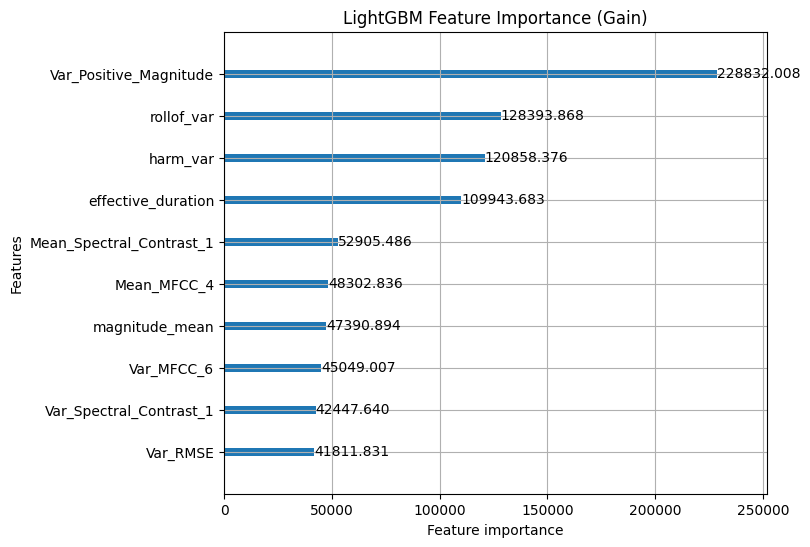

In [ ]:
# Plot feature importance
lgb.plot_importance(final_model,max_num_features=10, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

## Fine tunning-XGBoost

### Max depth and **min_child_weight**

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,12)
    for min_child_weight in range(3,8)
]

In [ ]:
# RMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_rounds,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse= cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=5, min_child_weight=3
	RMSE 9.186848603994116 for 499 rounds
CV with max_depth=5, min_child_weight=4
	RMSE 9.199803430358802 for 378 rounds
CV with max_depth=5, min_child_weight=5
	RMSE 9.191406509087216 for 499 rounds
CV with max_depth=5, min_child_weight=6
	RMSE 9.189985670867335 for 491 rounds
CV with max_depth=5, min_child_weight=7
	RMSE 9.142626252393002 for 499 rounds
CV with max_depth=6, min_child_weight=3
	RMSE 9.1970123567575 for 499 rounds
CV with max_depth=6, min_child_weight=4
	RMSE 9.14233225617745 for 499 rounds
CV with max_depth=6, min_child_weight=5
	RMSE 9.256817081853285 for 480 rounds
CV with max_depth=6, min_child_weight=6
	RMSE 9.222000686890592 for 407 rounds
CV with max_depth=6, min_child_weight=7
	RMSE 9.179515855674419 for 475 rounds
CV with max_depth=7, min_child_weight=3
	RMSE 9.310589860427346 for 499 rounds
CV with max_depth=7, min_child_weight=4
	RMSE 9.26956998896404 for 487 rounds
CV with max_depth=7, min_child_weight=5
	RMSE 9.27520695

In [ ]:
params['max_depth'] = 6
params['min_child_weight'] = 4

### subsample, colsample_bytree

In [ ]:
gridsearch_params = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(7,11)]
    for colsample_bytree in [i/10. for i in range(7,11)]
]

In [ ]:
# RMSE
min_rmse = float("Inf")
best_params = None
for subsample, colsample_bytree in  reversed(gridsearch_params):

  print("CV with subsample={}, colsample_bytree={}".format(
                            subsample,
                            colsample_bytree))
  # Update our parameters
  params['subsample'] = subsample
  params['colsample_bytree'] = colsample_bytree
  # Run CV
  cv_results = xgb.cv(
      params,
      dtrain,
      num_boost_round=num_rounds,
      seed=42,
      nfold=5,
      metrics={'rmse'},
      early_stopping_rounds=10
  )
  # Update best MAE
  mean_rmse= cv_results['test-rmse-mean'].min()
  boost_rounds = cv_results['test-rmse-mean'].argmin()
  print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
  if mean_rmse < min_rmse:
      min_rmse = mean_rmse
      best_params = (subsample,colsample_bytree)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample_bytree=1.0
	RMSE 9.14233225617745 for 499 rounds
CV with subsample=1.0, colsample_bytree=0.9
	RMSE 9.134114328971854 for 452 rounds
CV with subsample=1.0, colsample_bytree=0.8
	RMSE 9.126021619096463 for 499 rounds
CV with subsample=1.0, colsample_bytree=0.7
	RMSE 9.10383513964404 for 499 rounds
CV with subsample=0.9, colsample_bytree=1.0
	RMSE 9.096584905774689 for 499 rounds
CV with subsample=0.9, colsample_bytree=0.9
	RMSE 9.056357746105988 for 467 rounds
CV with subsample=0.9, colsample_bytree=0.8
	RMSE 9.007305437670807 for 449 rounds
CV with subsample=0.9, colsample_bytree=0.7
	RMSE 9.055560581647834 for 353 rounds
CV with subsample=0.8, colsample_bytree=1.0
	RMSE 8.98596223840006 for 499 rounds
CV with subsample=0.8, colsample_bytree=0.9
	RMSE 9.005547149053488 for 496 rounds
CV with subsample=0.8, colsample_bytree=0.8
	RMSE 8.99378935813251 for 499 rounds
CV with subsample=0.8, colsample_bytree=0.7
	RMSE 9.017511097811905 for 455 rounds
CV with 

In [ ]:
  params['subsample'] = 0.8
  params['colsample_bytree'] = 0.1

### Eta

In [ ]:
# RMSE
min_rmse = float("Inf")
best_params = 0
for eta in [.3, .2, .1, .05, .01, .005, .001, .0005]:

  print("CV with eta={}".format(eta))
  # Update our parameters
  params['eta'] = eta

  # Run CV
  cv_results = xgb.cv(
      params,
      dtrain,
      num_boost_round=num_rounds,
      seed=42,
      nfold=5,
      metrics={'rmse'},
      early_stopping_rounds=20
  )
  # Update best MAE
  mean_rmse= cv_results['test-rmse-mean'].min()
  boost_rounds = cv_results['test-rmse-mean'].argmin()
  print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
  if mean_rmse < min_rmse:
      min_rmse = mean_rmse
      best_params = eta
print("Best params: {},  RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
	RMSE 10.424041636240304 for 6 rounds
CV with eta=0.2
	RMSE 9.814973954973873 for 56 rounds
CV with eta=0.1
	RMSE 9.557481096741503 for 100 rounds
CV with eta=0.05
	RMSE 9.282857079330872 for 314 rounds
CV with eta=0.01
	RMSE 9.103106046571833 for 499 rounds
CV with eta=0.005
	RMSE 9.409444382540249 for 499 rounds
CV with eta=0.001
	RMSE 10.996678482409072 for 499 rounds
CV with eta=0.0005
	RMSE 11.533126392021757 for 499 rounds
Best params: 0.01,  RMSE: 9.103106046571833


In [ ]:
 params['eta'] = 0.01

## Fine tunning- Lightgbm

### Learning rate and num_boost_round


In [ ]:
gridsearch_params = [
    (learning_rate, num_boost_rounds)
    for learning_rate in np.round(np.linspace(0.001, 0.5, num=10),3)
    for num_boost_rounds in range(200,1100,100)
]

In [ ]:
# RMSE
min_rmse = float("Inf")
best_params = None
for learning_rate, num_boost_round in  reversed(gridsearch_params):

  print("CV with learning_rate={}, num_boost_round={}".format(
                            learning_rate,
                            num_boost_round))
  # Update our parameters
  params_lgb['learning_rate'] = learning_rate
  params_lgb['num_boost_round'] = num_boost_round
  # Run CV
  cv_results =  lgb.cv(
      params_lgb,
      d_train,
      nfold=5,  # Number of folds in cross-validation
      metrics='rmse',
      stratified=False,
      seed=42
  )
  # Extract the optimal number of rounds based on early stopping
  optimal_rounds = np.argmin(cv_results['valid rmse-mean'])
  mean_rmse = cv_results['valid rmse-mean'][optimal_rounds]
  print("\tRMSE {} for {} rounds".format(mean_rmse, optimal_rounds ))

  if mean_rmse < min_rmse:
      min_rmse = mean_rmse
      best_params = (learning_rate,num_boost_round)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with learning_rate=0.5, num_boost_round=1000


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=900
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=800
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=700
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=600
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=500
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=400
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=300
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.5, num_boost_round=200
	RMSE 9.869722133938629 for 3 rounds
CV with learning_rate=0.445, num_boost_round=1000
	RMSE 9.890583577904426 for 2 rounds
CV with learning_rate=0.445, num_boost_round=900
	RMSE 9.890583577904426 for 2 rounds
CV with learning_rate=0.445, num_boost_round=800
	RMSE 9.890583577904426 for 2 rounds
CV with learning_rate=0.445, num

In [ ]:
params_lgb['learning_rate'] = 0.05
params_lgb['num_boost_round'] = 1000

### max bin


In [ ]:
gridsearch_params = [
    (max_bin)
    for max_bin in range(200,700,10)
]

In [ ]:
# RMSE
min_rmse = float("Inf")
best_params = None
for max_bin in  gridsearch_params:

  print("CV with max_bin = {}".format(max_bin))
  # Update our parameters
  params_lgb['max_bin'] = max_bin
  d_train= lgb.Dataset(X, label=y)

  # Run CV
  cv_results =  lgb.cv(
      params_lgb,
      d_train,
      nfold=5,  # Number of folds in cross-validation
      metrics='rmse',
      stratified=False,
      seed=42
  )
  # Extract the optimal number of rounds based on early stopping

  optimal_rounds = np.argmin(cv_results['valid rmse-mean'])
  mean_rmse = cv_results['valid rmse-mean'][optimal_rounds]
  print("\tRMSE {} for {} rounds".format(mean_rmse, optimal_rounds))

  if mean_rmse < min_rmse:
      min_rmse = mean_rmse
      best_params = max_bin

print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with max_bin = 200
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
	RMSE 8.97620954095478 for 115 rounds
CV with max_bin = 210
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.981887132926705 for 93 rounds
CV with max_bin = 220
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.98585742239894 for 94 rounds
CV with max_bin = 230
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.043650721699946 for 79 rounds
CV with max_bin = 240
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.044504309952327 for 114 rounds
CV with max_bin = 250
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.025669350308963 for 79 rounds
CV with max_bin = 260
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.013144428877592 for 70 rounds
CV with max_bin = 270
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.997575631161691 for 108 rounds
CV with max_bin = 280
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.033096961263986 for 95 rounds
CV with max_bin = 290
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.987313926188602 for 128 rounds
CV with max_bin = 300
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.036250478647759 for 77 rounds
CV with max_bin = 310
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.98821362374414 for 82 rounds
CV with max_bin = 320
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.013922298073195 for 101 rounds
CV with max_bin = 330
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.00000831469814 for 96 rounds
CV with max_bin = 340
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.942523411841552 for 79 rounds
CV with max_bin = 350
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.013257658136654 for 93 rounds
CV with max_bin = 360
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.091299468381676 for 109 rounds
CV with max_bin = 370
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.055489047872173 for 96 rounds
CV with max_bin = 380
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.017012494013148 for 76 rounds
CV with max_bin = 390
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.977594197541695 for 94 rounds
CV with max_bin = 400
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.011555241206153 for 143 rounds
CV with max_bin = 410
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.937310634023472 for 115 rounds
CV with max_bin = 420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.974280256976868 for 114 rounds
CV with max_bin = 430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.971956359633051 for 96 rounds
CV with max_bin = 440
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.959995265777986 for 110 rounds
CV with max_bin = 450
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.932967728339566 for 117 rounds
CV with max_bin = 460
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.970666265306452 for 105 rounds
CV with max_bin = 470
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.98249914653123 for 93 rounds
CV with max_bin = 480
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.01420847143999 for 111 rounds
CV with max_bin = 490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.964644315479749 for 109 rounds
CV with max_bin = 500
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.002821741610866 for 93 rounds
CV with max_bin = 510
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.002482791567465 for 119 rounds
CV with max_bin = 520
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 530
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 540
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 550
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 560
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 570
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 580
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.995108013345128 for 106 rounds
CV with max_bin = 590
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 600
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 610
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 620
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 630
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 640
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 650
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 660
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 670
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 680
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
CV with max_bin = 690
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.996437721715402 for 102 rounds
Best params: 450, RMSE: 8.932967728339566


In [ ]:
params_lgb['max_bin'] =  450

### num_leaves

In [ ]:
gridsearch_params = [
    (num_leaves)
    for num_leaves in range(5,100,5)
]

In [ ]:
# RMSE
min_rmse = float("Inf")
best_params = None
for num_leaves in  gridsearch_params:

  print("CV with num_leaves= {}".format(num_leaves))
  # Update our parameters
  params_lgb['num_leaves'] = num_leaves
  d_train= lgb.Dataset(X, label=y)

  # Run CV
  cv_results =  lgb.cv(
      params_lgb,
      d_train,
      nfold=5,  # Number of folds in cross-validation
      metrics='rmse',
      stratified=False,
      seed=42
  )
  # Extract the optimal number of rounds based on early stopping

  optimal_rounds = np.argmin(cv_results['valid rmse-mean'])
  mean_rmse = cv_results['valid rmse-mean'][optimal_rounds]
  print("\tRMSE {} for {} rounds".format(mean_rmse, optimal_rounds))

  if mean_rmse < min_rmse:
      min_rmse = mean_rmse
      best_params = num_leaves

print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with num_leaves= 5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.005891958495985 for 373 rounds
CV with num_leaves= 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.878832764463361 for 136 rounds
CV with num_leaves= 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.92118617667063 for 126 rounds
CV with num_leaves= 20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 9.012514763820501 for 145 rounds
CV with num_leaves= 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.99526061982571 for 117 rounds
CV with num_leaves= 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


	RMSE 8.978491227784591 for 94 rounds
CV with num_leaves= 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
	RMSE 8.934332565725999 for 93 rounds
CV with num_leaves= 40
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:685: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

# Train fine tuned

### XGBoost

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_rounds,
    nfold=5,  # Number of folds in cross-validation
    metrics={'rmse'}
    early_stopping_rounds= 20,  # Stop training if no improvement in 10 rounds
    seed=42
)

# Extract the optimal number of rounds based on early stopping
optimal_rounds = np.argmin(cv_results['test-rmse-mean'])

# Train the final model with the optimal number of rounds
final_model = xgb.train(params, dtrain, num_boost_round=optimal_rounds)

# Evaluate the final model
y_pred = final_model.predict(dtrain)
rmse = mean_squared_error(y, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE) on full dataset: {rmse}')


Root Mean Squared Error (RMSE) on full dataset: 2.8182550057173272


## LightGBM

In [ ]:
cv_results =  lgb.cv(
    params_lgb,
    d_train,
    num_boost_round=1000,
    nfold=5,  # Number of folds in cross-validation
    metrics='rmse',
    stratified=False,
    seed=42
)

# Extract the optimal number of rounds based on early stopping
optimal_rounds = np.argmin(cv_results['valid rmse-mean'])
print('RMSE test:', cv_results['valid rmse-mean'][optimal_rounds])

# Train the final model with the optimal number of rounds
final_model = lgb.train(params_lgb , d_train, num_boost_round=optimal_rounds)

# Evaluate the final model
y_pred = final_model.predict(X)
rmse = mean_squared_error(y, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE) on full dataset: {rmse}')

NameError: name 'lgb' is not defined

# Submission

## XGBoost

In [ ]:
X_test  = test_ds[test_ds.columns.difference(['id','mp3_file_path','input_audio','sample_rate'])]

In [ ]:
dtest = xgb.DMatrix(X_test)

In [ ]:
# Evaluate the final model
y_submission = final_model.predict(dtest)

In [ ]:
df_test['prediction'] = np.round(y_submission)

In [ ]:
df_test[['id','prediction']].to_csv('submission.csv',index=False)

### LightGBM


In [ ]:
X_test  = test_ds[test_ds.columns.difference(['id','mp3_file_path','input_audio','sample_rate'])]

In [ ]:
# Evaluate the final model
y_submission = final_model.predict(X_test)

In [ ]:
df_test['prediction'] = y_submission

In [ ]:
df_test[['id','prediction']].to_csv('submission_lgbm.csv',index=False)